오차역전파법 TwoLayerNet를 참조하여 다음 조건에 맞는 코드를 작성한다.

조건 1. 반복 횟수는 10000번

조건 2. learning_rate = ( 0.001 ~ 0.019 사이 ) 

조건 3. hidden_size = (  5 ~ 15 사이 )

조건 4. Affine 계층을 반드시 늘려야 함 ( 현재 2층이므로 3층 이상 )

% 조건에 해당하지 않는 셋팅을 한 경우 감점 처리 ( 각 -1점, Affine 계층 : -2점) 

In [1]:
# coding: utf-8
import sys, os
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

class MultiLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        # 가중치 초기화
        # 가중치 초깃값을 0.01이 아닌 He 초깃값을 사용하도록 수정하였다.
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        
        return grads

0.09065 0.0927
0.5797666666666667 0.5824
0.7946666666666666 0.7961
0.8357666666666667 0.8402
0.8513833333333334 0.8567
0.8639333333333333 0.8702
0.8730166666666667 0.8794
0.8807166666666667 0.8865
0.8881 0.8933
0.8914333333333333 0.8957
0.8967666666666667 0.9006
0.9003 0.9019
0.90415 0.909
0.9072333333333333 0.9106
0.9088 0.9115
0.9121833333333333 0.9125
0.9137833333333333 0.9169


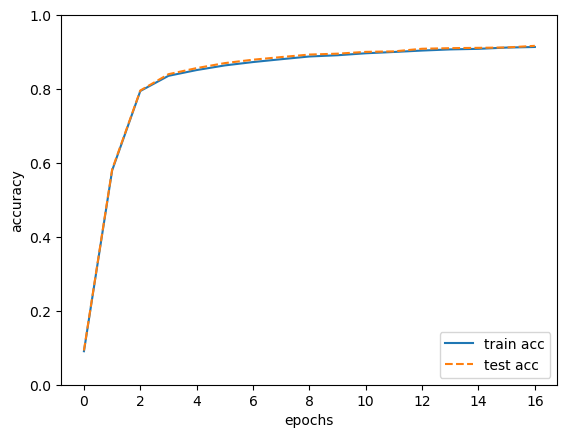

In [3]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = MultiLayerNet(input_size=784, hidden_size=10, output_size=10) # hidden_size 변경

iters_num = 10000 # 반복 횟수는 10000번
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01 # learning_rate 변경

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()